In [31]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored
import matplotlib.pyplot as plt

from pathlib import Path

import dill
import pickle
import arviz as az

# GP Kernel Function

In [32]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [33]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


# Aggregation Functions

In [34]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

# Aggregated Prevalence Model - must edit this to include HDI, population density



In [35]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    pop_density_lo = args["pop_density_lo"]  # (4,) one province (jkt) for 4 yrs' data
    pop_density_hi = args["pop_density_hi"]  # (24,)

    #aggregate pop_density tgt
    pop_density = jnp.concatenate([pop_density_lo,pop_density_hi], axis = 0)

    #aggregate hdi tgt

    hdi_lo = args["hdi_lo"]  # (4,) 6 districts within jkt for 4 yrs' data
    hdi_hi = args["hdi_hi"]  # (24,)
    hdi = jnp.concatenate([hdi_lo,hdi_hi], axis = 0)

    urban_lo = args["urban_lo"]  # (4,) 6 districts within jkt for 4 yrs' data
    urban_hi = args["urban_hi"]  # (24,)
    urban = jnp.concatenate([urban_lo,urban_hi], axis = 0)

    M_lo = args["M_lo"]  # (4, num_grid_points) aggregation matrix
    M_hi = args["M_hi"]  # (24, num_grid_points) aggregation matrix

    total_cases_lo = args["total_cases_lo"] #cos we wanna predict total cases district-wise, so only feed total cases for low res data

    total_population_lo = args["total_population_lo"]
    total_population_hi = args["total_population_hi"]

    #aggregate total populations low and high
    total_population = jnp.concatenate([total_population_lo,total_population_hi], axis = 0)

    #add NaN values to total_cases to accommodate for unavailable total cases data for high resolution (that we want to predict)
    total_cases = jnp.pad(total_cases_lo, (0, M_hi.shape[0]),constant_values = 0.0) #[3762.  484. ... , 0,0,0]
    total_cases = jnp.where(total_cases == 0, jnp.nan, total_cases)# [3762.  484. ... , nan,nan,nan]
    total_cases_mask = ~jnp.isnan(total_cases) # [True, True, ...., False, False, False]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr_lo = numpyro.deterministic("gp_aggr_lo", M_g(M_lo, f))  # (4,)
    gp_aggr_hi = numpyro.deterministic("gp_aggr_hi", M_g(M_hi, f))  # (24,)

    # Now we need to aggregate both. This step is important since even though we only
    # show the model the low resolution data, to produce high resolution data it
    # needs th GP realizations for those regions
    gp_aggr = numpyro.deterministic("gp_aggr", jnp.concatenate([gp_aggr_lo,gp_aggr_hi])) #(28,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi + b_urban * urban  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp) * 1e-2)  # (num_districts,)

    # Binomial likelihood
    with numpyro.handlers.mask(mask=total_cases_mask):
        observed_cases = numpyro.sample(
            "observed_cases",
            dist.Binomial(total_count=total_population, probs=theta),
            obs=total_cases)

    return observed_cases


# Load Data

In [36]:
# Lat/Lon Values of artificial grid
x = np.load("../data/lat_lon_x_jkt.npy")

# combined regional data
pol_pts_jkt_lo = np.load("../data/pol_pts_jkt_lo.npy")
pt_which_pol_jkt_lo = np.load("../data/pt_which_pol_jkt_lo.npy")
pol_pts_jkt_hi = np.load("../data/pol_pts_jkt_hi.npy")
pt_which_pol_jkt_hi = np.load("../data/pt_which_pol_jkt_hi.npy")

#combine the dataframes
df_lo = gpd.read_file("../data/jkt_prov.shp")
df_hi = gpd.read_file("../data/jkt_dist.shp")

# Vars needed to be changed (change according to the agg prevalence model parameters)

In [37]:
M_lo = jnp.array(pol_pts_jkt_lo)
M_hi = jnp.array(pol_pts_jkt_hi)
pop_density_lo = jnp.array(df_lo["popden_qt"])
pop_density_hi = jnp.array(df_hi["popden_qt"])
hdi_lo = jnp.array(df_lo["hdi_qt"])
hdi_hi = jnp.array(df_hi["hdi_qt"])
urban_lo = jnp.array(df_lo["urban_qt"])
urban_hi = jnp.array(df_hi["urban_qt"])
cases_lo = jnp.array(df_lo["Cases"])
pop_lo = jnp.array(df_lo["Population"])
pop_hi = jnp.array(df_hi["Population"])

In [38]:
#print the shape of all the vars above
print(M_lo.shape)
print(M_hi.shape)
print(pop_density_lo.shape)
print(pop_density_hi.shape)
print(hdi_lo.shape)
print(hdi_hi.shape)
print(cases_lo.shape)
print(pop_lo.shape)
print(pop_hi.shape)
print(x.shape)

(4, 100)
(20, 100)
(4,)
(20,)
(4,)
(20,)
(4,)
(4,)
(20,)
(100, 2)


# Agg GP Model

In [39]:
args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M_lo" : M_lo, # Aggregation matrix # Shape (num_districts, num_districts)
        "M_hi" : M_hi, # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.LogNormal(-1, 0.5), #(,)
        "kernel_var" : dist.LogNormal(0, 1),
        "pop_density_lo": pop_density_lo, # Shape (num_districts,)
        "pop_density_hi": pop_density_hi, # Shape (num_districts,)
        "hdi_lo": hdi_lo, # Shape (num_districts, 2)
        "hdi_hi": hdi_hi, # Shape (num_districts, 2)
        "urban_lo": urban_lo,
        "urban_hi": urban_hi,
        "total_cases_lo" : cases_lo,
        "total_population_lo" : pop_lo,
        "total_population_hi" : pop_hi,
}


# Run MCMC

In [40]:
# Base seed for reproducibility
base_seed = 3  # Keep this fixed for full replicability


# MCMC settings
n_warm = 1000
n_samples = 2000

In [41]:
save_dir = Path.cwd().parent / "model weights" / "aggGP"

# Save Model

In [42]:
# Run MCMC with 1 chain at a time

for chain_id in range(4):
    print(f"Starting Chain {chain_id+1}/4...")

    # 🔹 Generate a unique but reproducible key for each chain
    chain_key = jax.random.fold_in(jax.random.PRNGKey(base_seed), chain_id)

    mcmc = MCMC(
        NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=1  # Run one chain at a time
    )

    start = time.time()
    try:
        mcmc.run(chain_key, args)  # Use the fixed but different seed for each chain
        end = time.time()
        t_elapsed_min = round((end - start) / 60)

        # 🔹 Save after each successful chain
        f_path = f"{save_dir}/aggGP_chain{chain_id+1}_nsamples_{n_samples}_tt{t_elapsed_min}min.pkl"
        with open(f_path, "wb") as file:
            dill.dump(mcmc, file)

        print(f"Saved Chain {chain_id+1} to {f_path}")

    except Exception as e:
        print(f"Error occurred in Chain {chain_id+1}: {e}")
        break  # Stop if an error occurs

Starting Chain 1/4...


sample: 100%|██████████| 3000/3000 [23:55<00:00,  2.09it/s, 767 steps of size 2.94e-03. acc. prob=0.92] 


Saved Chain 1 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain1_nsamples_2000_tt24min.pkl
Starting Chain 2/4...


sample: 100%|██████████| 3000/3000 [37:15<00:00,  1.34it/s, 1023 steps of size 1.02e-06. acc. prob=0.97]


Saved Chain 2 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain2_nsamples_2000_tt37min.pkl
Starting Chain 3/4...


sample: 100%|██████████| 3000/3000 [11:08<00:00,  4.49it/s, 1023 steps of size 2.78e-03. acc. prob=0.93]


Saved Chain 3 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain3_nsamples_2000_tt11min.pkl
Starting Chain 4/4...


sample: 100%|██████████| 3000/3000 [38:53<00:00,  1.29it/s, 1023 steps of size 6.49e-08. acc. prob=0.81]    

Saved Chain 4 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain4_nsamples_2000_tt39min.pkl


# Results Inference

In [43]:
# Directory where chains are saved (sibling to `src`)
model_weights_path = Path.cwd().parent / "model weights" / "aggGP"

print(f"Looking in: {model_weights_path}")

# Load all chains
all_samples = []
for chain_id in range(4):  # Assuming 4 chains were run
    file_prefix = f"aggGP_chain{chain_id+1}_nsamples_{n_samples}_tt"

    # Find all matching files
    matching_files = sorted([
        f.name for f in model_weights_path.iterdir()
        if f.name.startswith(file_prefix)
    ])

    if not matching_files:
        print(f"Warning: No file found for chain {chain_id+1}")
        continue

    # Load the most recent matching file
    latest_file = model_weights_path / matching_files[-1]
    with open(latest_file, "rb") as file:
        mcmc = dill.load(file)

    # Extract and store samples
    samples = mcmc.get_samples()
    all_samples.append(samples)
    print(f"Loaded chain {chain_id+1} from {latest_file.name}")

# Stack samples into (num_chains, num_samples, ...) format
if all_samples:
    samples_grouped = {
        k: jnp.stack([chain[k] for chain in all_samples], axis=0)
        for k in all_samples[0].keys()
    }
    print("Successfully grouped all chains for diagnostics.")
else:
    samples_grouped = None
    print("No chains loaded.")

Looking in: c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP
Loaded chain 1 from aggGP_chain1_nsamples_2000_tt24min.pkl
Loaded chain 2 from aggGP_chain2_nsamples_2000_tt37min.pkl
Loaded chain 3 from aggGP_chain3_nsamples_2000_tt15min.pkl
Loaded chain 4 from aggGP_chain4_nsamples_2000_tt39min.pkl
Successfully grouped all chains for diagnostics.


In [44]:
samples = samples_grouped

In [45]:
#view the theta
samples["theta"]

Array([[[0.00173812, 0.00177417, 0.0018219 , ..., 0.00628209,
         0.00628505, 0.00628366],
        [0.00170162, 0.00173409, 0.00177702, ..., 0.00632096,
         0.00632366, 0.00632241],
        [0.00181074, 0.00182376, 0.0018408 , ..., 0.00581949,
         0.00582171, 0.00583273],
        ...,
        [0.00173763, 0.00176495, 0.00180096, ..., 0.00311786,
         0.00311467, 0.00306096],
        [0.00179839, 0.00181902, 0.00184612, ..., 0.00398499,
         0.00397994, 0.00391134],
        [0.00178631, 0.0018053 , 0.00183022, ..., 0.00495133,
         0.00495193, 0.00494076]],

       [[0.00133372, 0.00142576, 0.00155324, ..., 0.00206725,
         0.00208332, 0.0021789 ],
        [0.00133371, 0.00142575, 0.00155323, ..., 0.00206725,
         0.00208332, 0.0021789 ],
        [0.00133372, 0.00142576, 0.00155324, ..., 0.00206724,
         0.00208331, 0.0021789 ],
        ...,
        [0.00133397, 0.00142603, 0.00155352, ..., 0.00206737,
         0.00208344, 0.00217903],
        [0.0

In [46]:
#assess the R hat, ESS etc.,
n_lo = df_lo.shape[0]
n_hi = df_hi.shape[0]

ss = numpyro.diagnostics.summary(samples_grouped)
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 15
Average ESS for all aggGP-low effects : 3
Max r_hat for all aggGP-low : 1.8200000524520874
Average ESS for all aggGP-high effects : 17
Max r_hat for all aggGP-high : 2.430000066757202
kernel_length R-hat : 1.2300000190734863
kernel_var R-hat : 14.489999771118164


In [47]:
# Convert summary stats to a DataFrame for better readability
df_summary = pd.DataFrame.from_dict(ss, orient="index")
print(df_summary)

                                                            mean  \
b0                                                     -0.224036   
b_hdi                                                   0.406865   
b_pop_density                                           0.324404   
b_urban                                                  0.13374   
f              [0.10315259, -0.053858086, -0.06311854, -0.121...   
gp_aggr        [-2.1087813, -2.1087813, -2.1087813, -2.108781...   
gp_aggr_hi     [-1.4142168, -1.4142168, -1.4142168, -1.414216...   
gp_aggr_lo      [-2.1087813, -2.1087813, -2.1087813, -2.1087813]   
kernel_length                                            0.86419   
kernel_var                                              5.888467   
theta          [0.0016579158, 0.0016991365, 0.0017549796, 0.0...   

                                                             std  \
b0                                                      1.221258   
b_hdi                                          

ValueError: Too many bins for data range. Cannot create 512 finite-sized bins.

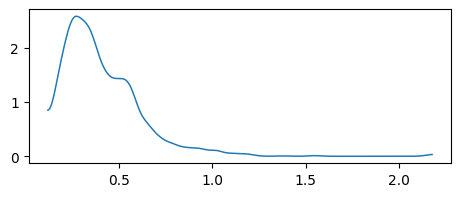

In [48]:
# Convert manually combined samples into an ArviZ InferenceData object
case_samples_az_gp = az.from_dict(posterior=samples_grouped)

# Plot trace plots for kernel_length and kernel_var
az.plot_trace(case_samples_az_gp, var_names=["kernel_length"])
az.plot_trace(case_samples_az_gp, var_names=["kernel_var"])

### Calculate and append observed and gp-estimated theta

In [ ]:
samples["theta"].shape

(4, 2000, 24)

In [ ]:
theta_mean_gp = samples["theta"].mean(axis = (0, 1))
bci_gp_25 = np.quantile(samples["theta"],0.25,axis = (0, 1))
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = (0, 1))
# Slice IQR values to match low-res and high-res
bci_lo_25 = bci_gp_25[:n_lo]
bci_lo_75 = bci_gp_75[:n_lo]

bci_hi_25 = bci_gp_25[n_lo:n_lo + n_hi]
bci_hi_75 = bci_gp_75[n_lo:n_lo + n_hi]


df_lo["obs_prev"] = df_lo["Cases"] / df_lo["Population"]
df_hi["obs_prev"] = df_hi["Cases"] / df_hi["Population"]

df_lo["theta_gp"] = theta_mean_gp[0:n_lo]
df_hi["theta_gp"] = theta_mean_gp[n_lo:n_lo + n_hi]

theta_obs_lo = df_lo["obs_prev"]
theta_gp_est_lo = df_lo["theta_gp"]
theta_obs_hi = df_hi["obs_prev"]
theta_gp_est_hi = df_hi["theta_gp"]

max_val_lo = np.max([theta_obs_lo, theta_gp_est_lo])
min_val_lo = np.min([theta_obs_lo, theta_gp_est_lo])

max_val_hi = np.max([theta_obs_hi, theta_gp_est_hi])
min_val_hi = np.min([theta_obs_hi, theta_gp_est_hi])

# Plot the map

##  (low-res)

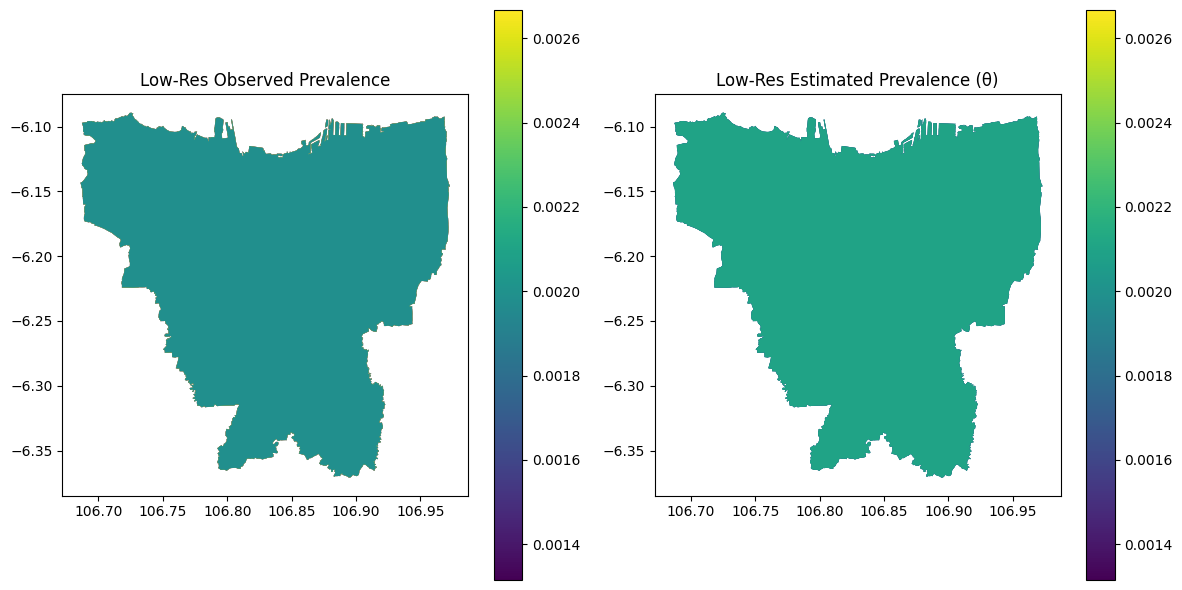

<Figure size 800x600 with 0 Axes>

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_lo.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_lo,  # Minimum value for color scale
    vmax=max_val_lo,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("Low-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_lo.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_lo,  # Minimum value for color scale
    vmax=max_val_lo,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("Low-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_lo.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence_lo.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

## high-res

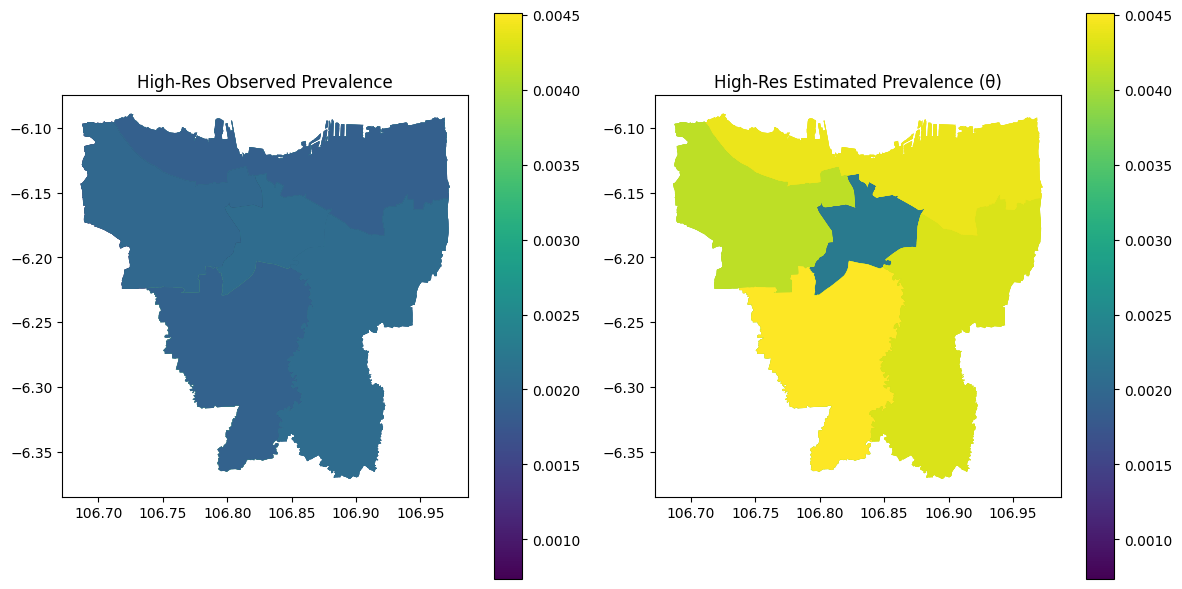

<Figure size 800x600 with 0 Axes>

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_hi.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("High-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_hi.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("High-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_hi.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

### Plot scatterplot

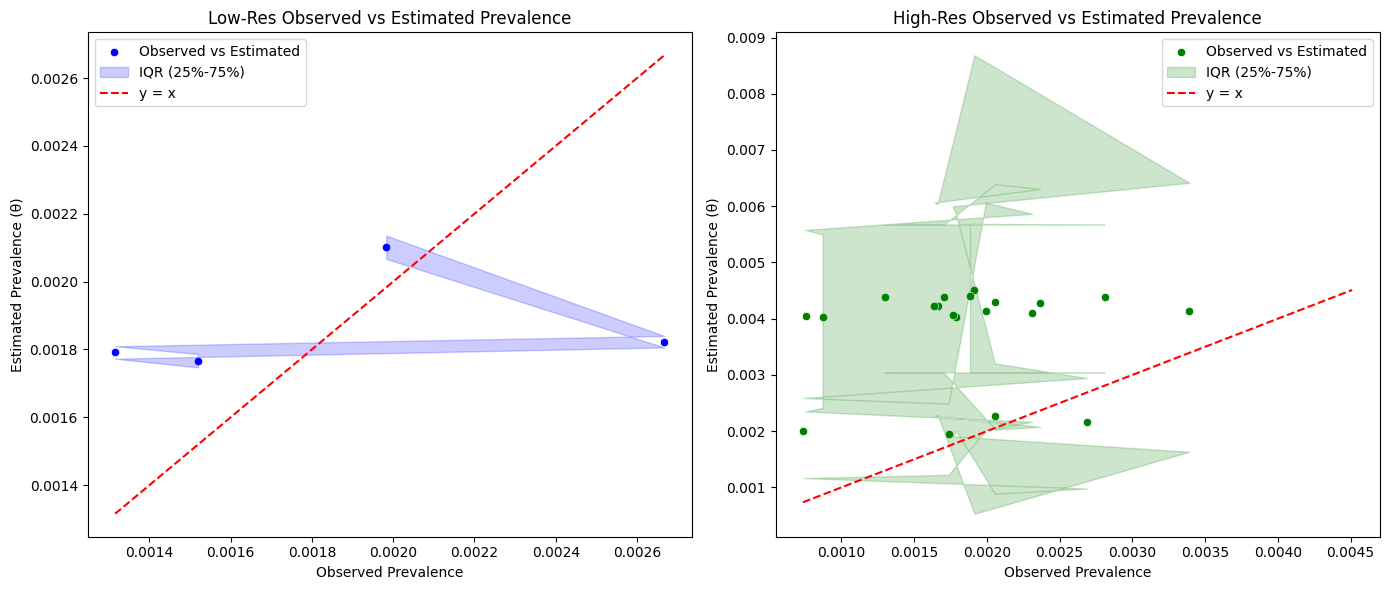

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert JAX arrays to NumPy arrays before plotting
def plot_scatter(ax, df, bci_25, bci_75, title, color):
    theta_obs = np.asarray(df["obs_prev"])
    theta_gp_est = np.asarray(df["theta_gp"])
    bci_25 = np.asarray(bci_25)
    bci_75 = np.asarray(bci_75)

    # Compute min and max for plot limits
    _max = max(theta_obs.max(), theta_gp_est.max())
    _min = min(theta_obs.min(), theta_gp_est.min())

    # Scatter plot of observed vs estimated prevalence
    sns.scatterplot(x=theta_obs, y=theta_gp_est, label="Observed vs Estimated", color=color, ax=ax)

    # Add IQR shaded region
    ax.fill_between(theta_obs, bci_25, bci_75, color=color, alpha=0.2, label="IQR (25%-75%)")

    # Plot reference line (y = x) for comparison
    sns.lineplot(x=[_min, _max], y=[_min, _max], color="red", linestyle="--", label="y = x", ax=ax)

    ax.set_xlabel("Observed Prevalence")
    ax.set_ylabel("Estimated Prevalence (θ)")
    ax.set_title(title)
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_scatter(axes[0], df_lo, bci_lo_25, bci_lo_75, "Low-Res Observed vs Estimated Prevalence", "blue")
plot_scatter(axes[1], df_hi, bci_hi_25, bci_hi_75, "High-Res Observed vs Estimated Prevalence", "green")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("observed_vs_estimated_prevalence_scatter_side_by_side.png")
plt.show()

In [ ]:
#save df
df_lo.to_csv("../data/df_with_gp_preds_lowres.csv")
df_lo.to_file("../data/df_with_gp_preds_lowres.shp")
df_hi.to_file("../data/df_with_gp_preds_highres.shp")
df_hi.to_csv("../data/df_with_gp_preds_highres.csv")